# CNN LAB - part A
Note that current lab is not aiming at defining optimal model. Focus is rather on roughly exploring some basic concepts using very limited hardvare resources (CPU or GoogleColab limited GPU).\
https://www.kaggle.com/datasets/alxmamaev/flowers-recognition

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random

### Help functions

In [ ]:
def plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies, test_loss, test_accuracy):
    plt.figure(figsize=(10, 3))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title(f'Loss (test loss = {test_loss:.4f})')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='train')
    plt.plot(val_accuracies, label='val')
    plt.title(f'Accuracy (test accuracy = {test_accuracy:.4f})')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.legend()
    plt.show()

def display_confusion_matrix(y_pred, y_test, labels_list):
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    # Confusion Matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels_list, yticklabels=labels_list)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


Images are saved in separate folders for each flower type

In [ ]:
# list of labels
labels_list = ['sunflower', 'tulip', 'daisy', 'rose', 'dandelion']

# directories where data is saved
dir_list = ['./data/sunflower/', './data/tulip/', './data/daisy/', './data/rose/', './data/dandelion/']

# google drive folders for Colab experiments
# dir_list = ['/content/drive/MyDrive/Colab Notebooks/lab_CNN/data/sunflower',
#             '/content/drive/MyDrive/Colab Notebooks/lab_CNN/data/tulip',
#             '/content/drive/MyDrive/Colab Notebooks/lab_CNN/data/daisy',
#             '/content/drive/MyDrive/Colab Notebooks/lab_CNN/data/rose',
#             '/content/drive/MyDrive/Colab Notebooks/lab_CNN/data/dandelion']

Create list X of images as arrays and list y with labels (0-4, with index corresponding to labels_list)

In [ ]:
X = []
y = []

for dir in dir_list:
    for filename in os.listdir(dir):
        path = os.path.join(dir, filename)
        img = Image.open(path).resize((150,150)) # read in image and resize
        img_array = tf.keras.utils.img_to_array(img) # trasform into array
        X.append(img_array)
        y.append(dir_list.index(dir))

Visualize random 10 flowers

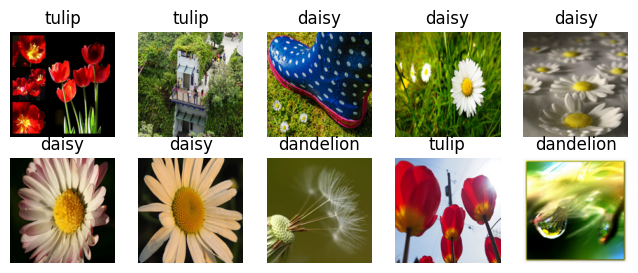

In [ ]:
random_indices = random.sample(range(1, len(X)), 10)
plt.figure(figsize=(8,3))
for i, index in enumerate(random_indices, 1):
    plt.subplot(2, 5, i)
    plt.imshow(tf.keras.utils.array_to_img(X[index]))
    plt.title(f"{labels_list[y[index]]}")
    plt.axis("off")
plt.show()

X: make array and normalize all 3 channels\
y: make array and apply one-hot encoding into 5 categories

In [ ]:
X_array = np.array(X) / 255.0

y_array = np.array(y)
y_array = to_categorical(y_array, len(labels_list))

X_array.shape, y_array.shape

((4317, 150, 150, 3), (4317, 5))

Split data into train, val and test (60:20:20)

In [ ]:
X_trainval, X_test, y_trainval, y_test =train_test_split(X_array, y_array, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val =train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((2589, 150, 150, 3),
 (864, 150, 150, 3),
 (864, 150, 150, 3),
 (2589, 5),
 (864, 5),
 (864, 5))

In [ ]:
def show_images(images, labels, num_rows=2, num_cols=2, scale=2):
    """Display a grid of images with labels."""
    _, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*scale, num_rows*scale))
    axs = axs.flatten()
    for img, ax, label in zip(images, axs, labels):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title('Label: ' + str(label))
    plt.show()

In [ ]:
def show_images(images, labels, num_rows=2, num_cols=2, scale=2):
    """Display a grid of images with labels."""
    _, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*scale, num_rows*scale))
    axs = axs.flatten()
    for img, ax, label in zip(images, axs, labels):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title('Label: ' + str(label))
    plt.show()

    l=rn.randint(0,len(X_train))

# Define basic model

In [ ]:
model_base = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), activation = 'relu', padding = 'same', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), activation = 'relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model_base.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 128)       0

27/27 - 0s - loss: 2.6739 - accuracy: 0.6539 - 287ms/epoch - 11ms/step


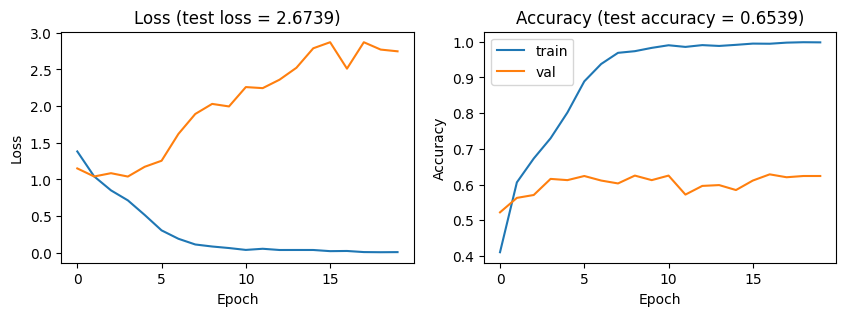

In [ ]:
history = model_base.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), verbose=0)
train_loss, train_accuracy, val_loss, val_accuracy = history.history.values()
test_loss, test_accuracy = model_base.evaluate(X_test, y_test, verbose=2)
plot_training_history(train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy)

Basic model is overfitting and has poor performance on test data.

27/27 [==============================] - 0s 14ms/step


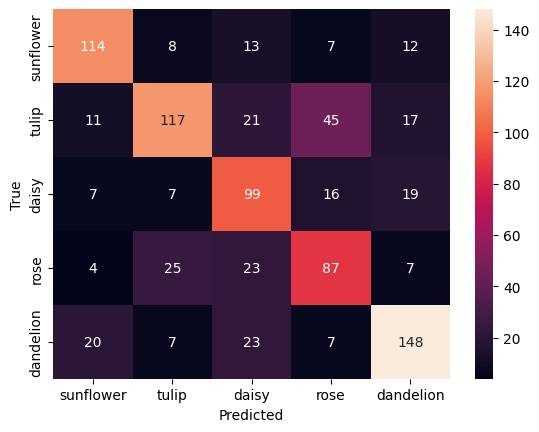

In [ ]:
y_pred = model_base.predict(X_test)
display_confusion_matrix(y_pred, y_test, labels_list)

Confusion matrix shows that rose is often confused with tulip and daisy. Rose seems to be the most difficult flower to classify correctly.\

# Models with regularization
Regularization techniques such as early stopping, dropouts, L2, fewer kernels and data augumentation can be applied to avoid overfitting. Some of the techniqes will be investigated below.

## 1. L2 regularization is added

In [ ]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), activation = 'relu', padding = 'same', kernel_regularizer = 'l2', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu', padding = 'same', kernel_regularizer = 'l2',),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), activation = 'relu', padding = 'same', kernel_regularizer = 'l2',),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer = 'l2'),
    tf.keras.layers.Dense(5, activation='softmax')
])
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_1.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

27/27 - 0s - loss: 1.1898 - accuracy: 0.6134 - 394ms/epoch - 15ms/step


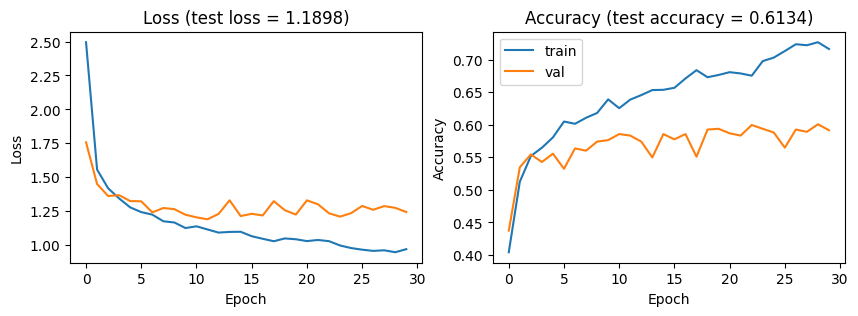

In [ ]:
# train and validate model
history = model_1.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), verbose=0) # callbacks=[early_stopping]
train_loss, train_accuracy, val_loss, val_accuracy = history.history.values()
test_loss, test_accuracy = model_1.evaluate(X_test, y_test, verbose=2)
plot_training_history(train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy)


L2 reduced overfitting to some extent but not fully.

## 2. Drop-out layers are added

In [ ]:
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), activation = 'relu', padding = 'same', kernel_regularizer = 'l2', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu', padding = 'same', kernel_regularizer = 'l2',),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), activation = 'relu', padding = 'same', kernel_regularizer = 'l2',),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer = 'l2'),
    tf.keras.layers.Dense(5, activation='softmax')
])

model_2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

27/27 - 0s - loss: 1.2633 - accuracy: 0.6019 - 310ms/epoch - 11ms/step


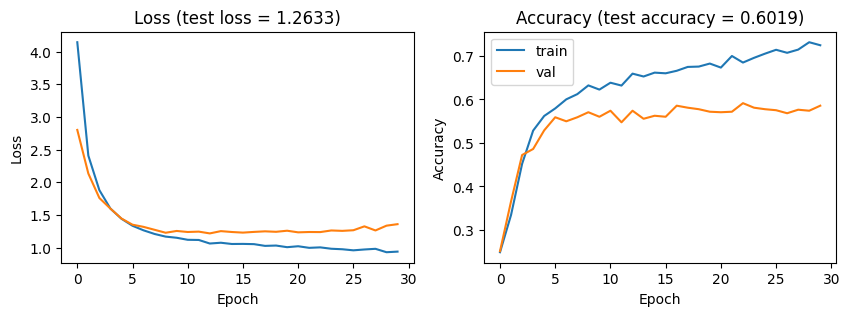

In [ ]:
history = model_2.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), verbose=0)
train_loss, train_accuracy, val_loss, val_accuracy = history.history.values()
test_loss, test_accuracy = model_2.evaluate(X_test, y_test, verbose=2)
plot_training_history(train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy)

 ## 3. Increase kernel size and number of kernals to improve accuracy.

In [ ]:
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (5, 5), strides = (1, 1), activation = 'relu', padding = 'same', kernel_regularizer = 'l2', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), activation = 'relu', padding = 'same', kernel_regularizer = 'l2',),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), activation = 'relu', padding = 'same', kernel_regularizer = 'l2',),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer = 'l2'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model_3.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

27/27 - 1s - loss: 1.2981 - accuracy: 0.5926 - 501ms/epoch - 19ms/step


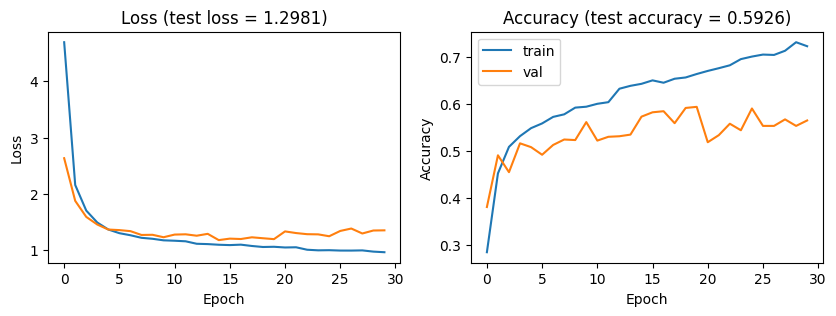

In [ ]:
history = model_3.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), verbose=0)
train_loss, train_accuracy, val_loss, val_accuracy = history.history.values()
test_loss, test_accuracy = model_3.evaluate(X_test, y_test, verbose=2)
plot_training_history(train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy)

Still sligltly overfitted. More filters did not improve accuracy.

## 4. Add Conv layer and neurons in dense layer to try improving accuracy

In [ ]:
model_4 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (5, 5), strides = (1, 1), activation = 'relu', padding = 'same', kernel_regularizer = 'l2', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu', padding = 'same', kernel_regularizer = 'l2'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), activation = 'relu', padding = 'same', kernel_regularizer = 'l2',),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), activation = 'relu', padding = 'same', kernel_regularizer = 'l2',),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer = 'l2'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model_4.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

27/27 - 0s - loss: 1.8405 - accuracy: 0.5752 - 413ms/epoch - 15ms/step


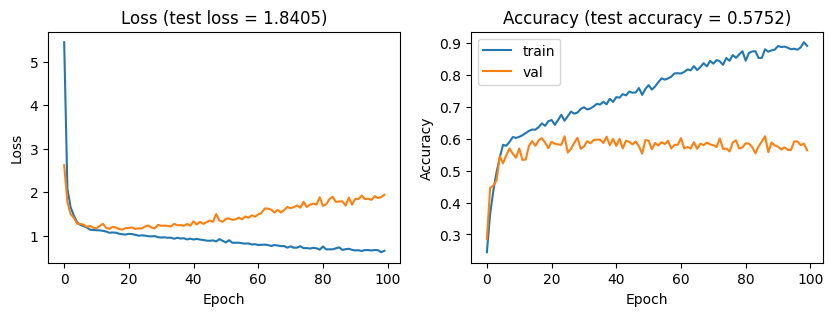

In [ ]:
history = model_4.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), verbose=0)
train_loss, train_accuracy, val_loss, val_accuracy = history.history.values()
test_loss, test_accuracy = model_4.evaluate(X_test, y_test, verbose=2)
plot_training_history(train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy)

Model seems to be overfitting still.

## 5. Reduce number of kernels and add additional drop-out layer to lower risk for overfitting

In [ ]:
model_5 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (5, 5), strides = (1, 1), activation = 'relu', padding = 'same', kernel_regularizer = 'l2', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu', padding = 'same', kernel_regularizer = 'l2'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu', padding = 'same', kernel_regularizer = 'l2',),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu', padding = 'same', kernel_regularizer = 'l2',),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer = 'l2'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model_5.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

27/27 - 0s - loss: 1.6559 - accuracy: 0.5428 - 388ms/epoch - 14ms/step


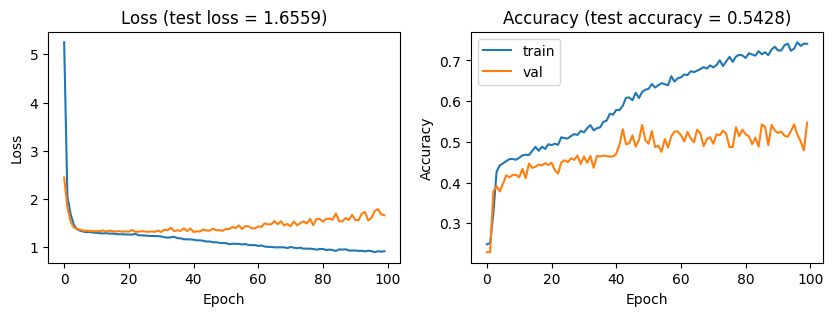

In [ ]:
history = model_5.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), verbose=0)
train_loss, train_accuracy, val_loss, val_accuracy = history.history.values()
test_loss, test_accuracy = model_5.evaluate(X_test, y_test, verbose=2)
plot_training_history(train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy)

No effect on overfitting or accuracy.

## 6. Test with data augumentation

<ipython-input-11-a8f72b9b1282>:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_5.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size), epochs = 50, validation_data = (X_val, y_val), verbose = 0, steps_per_epoch=X_train.shape[0] // batch_size)


27/27 - 0s - loss: 1.2042 - accuracy: 0.5602 - 276ms/epoch - 10ms/step


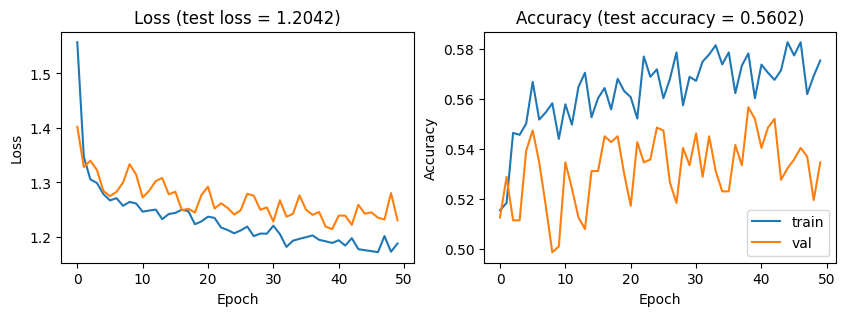

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

batch_size = 128
history = model_5.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size), epochs = 50, validation_data = (X_val, y_val), verbose = 0, steps_per_epoch=X_train.shape[0] // batch_size)
train_loss, train_accuracy, val_loss, val_accuracy = history.history.values()
test_loss, test_accuracy = model_5.evaluate(X_test, y_test, verbose=2)
plot_training_history(train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy)


Somewhat inproved issue of overfitting.


---
---
Model architecture:
* CNN with input size corresponding to X data
* increesing number of kernels through out the network
* Conv2D layers with the go to ReLU function and zero-padding
* maxpooling is applied, final layer is activated with softmax since it is a multi-classification problem with output 5
* loss function is 'categorical_crossentropy' which is suiable for multiclassification problem. \

Data was resized and normalized. One-shot classification was used to create output vectors for 5 categories.\
Model performance was evaluated by plotting training and validation losses and accuracies as function of epoches.\
Initial base model did not use any regularization. In subsequent models some reglarization techniques were tried to reduce overfitting such as L2, Drop-out layers, fewer kernals, data augumentation.\
Accuracy improvment was attempted with increased number and size of kernel with poor results.\
For further improvement probably more thorough data pre-treatment is required.\
Additionaly batch normalization layers could be added prior to Drop_out for each Conv-layer and possibly the Dense layer